## Visualizing gating variables in a LSTM

Here we will train a one-unit LSTM network and visualize its gating variables.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gyyang/nn-brain/blob/master/LSTMVisualization.ipynb)

In [1]:
import numpy as np


def memory_task(seq_len, batch_size, n_repeat=1):
    """Return a batch from a simple memory task."""
    inputs = np.zeros((seq_len * n_repeat, batch_size, 3))
    outputs = np.zeros((seq_len * n_repeat, batch_size, 1))

    for i in range(n_repeat):
        t_start = i * seq_len
        inputs[t_start:t_start+seq_len, :, 0] = np.random.uniform(-1, 1, size=(seq_len, batch_size))
        t_stim = np.random.randint(int(seq_len)/2, size=(batch_size,))
        t_test = np.random.randint(int(seq_len)/2, seq_len-1, size=(batch_size,))
        inputs[t_start + t_stim, range(batch_size), 1] = 1
        inputs[t_start + t_test, range(batch_size), 2] = 1

        outputs[t_start + t_test, range(batch_size), 0] = inputs[t_start + t_stim, range(batch_size), 0]
    
    return inputs, outputs

([<matplotlib.axis.YTick at 0x11736aa90>],
 <a list of 1 Text yticklabel objects>)

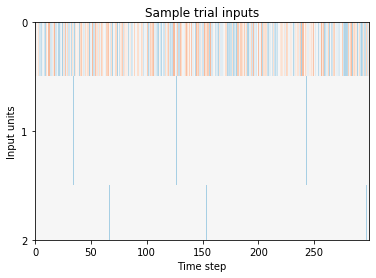

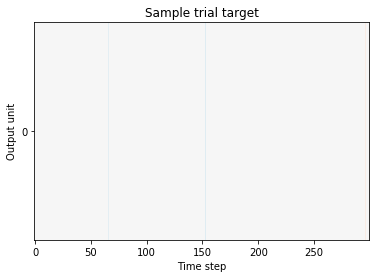

In [3]:
import matplotlib.pyplot as plt

inputs, outputs = memory_task(seq_len=100, batch_size=32, n_repeat=3)

plt.figure()
plt.imshow(inputs[:, 0, :].T, aspect='auto', vmin=-3, vmax=3, cmap='RdBu')
# plt.plot(inputs[:, 0, :].T)
plt.title('Sample trial inputs')
plt.xlabel('Time step')
plt.ylabel('Input units')
plt.yticks([0, 1, 2])

plt.figure()
plt.imshow(outputs[:, 0, :].T, aspect='auto', vmin=-3, vmax=3, cmap='RdBu')
plt.title('Sample trial target')
plt.xlabel('Time step')
plt.ylabel('Output unit')
plt.yticks([0])

###  Defining a LSTM network

Here we define a LSTM network explicitly using raw pytorch so we can access its gating variables.

In [4]:
from collections import defaultdict
import torch
import torch.nn as nn


class MyLSTM(nn.Module):
    """Manual implementation of LSTM."""

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.input2h = nn.Linear(input_size, 4*hidden_size)
        self.h2h = nn.Linear(hidden_size, 4*hidden_size)
        
        self.readout = False  # whether to readout activity

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        
        hx, cx = hidden
        gates = self.input2h(input) + self.h2h(hx)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, dim=1)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)
        
        if self.readout:
            result = {
                'ingate': ingate,
                'outgate': outgate,
                'forgetgate': forgetgate,
                'input': cellgate,
                'cell': cy,
                'output': hy,
            }
            return (hy, cy), result
        else:
            return hy, cy

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input)

        if not self.readout:
            # Regular forward
            output = []
            for i in range(input.size(0)):
                hidden = self.recurrence(input[i], hidden)
                output.append(hidden[0])

            output = torch.stack(output, dim=0)
            return output, hidden

        else:
            output = []
            result = defaultdict(list)  # dictionary with default as a list
            for i in range(input.size(0)):
                hidden, res = self.recurrence(input[i], hidden)
                output.append(hidden[0])
                for key, val in res.items():
                    result[key].append(val)

            output = torch.stack(output, dim=0)
            for key, val in result.items():
                result[key] = torch.stack(val, dim=0)

            return output, hidden, result
    

class Net(nn.Module):
    """Recurrent network model."""
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # self.rnn = nn.LSTM(input_size, hidden_size, **kwargs)
        self.rnn = MyLSTM(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        out = self.fc(rnn_activity)
        return out, rnn_activity

### Training the network

Loss should drop to almost 0 if the training is successful.

In [39]:
import torch.optim as optim
import time

# Using custom LSTM, ~30% slower on CPUs compare to native LSTM
# net = nn.LSTM(input_size=3, hidden_size=1)
# net = MyLSTM(input_size=3, hidden_size=1)
net = Net(input_size=3, hidden_size=1, output_size=1)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

running_loss = 0
start_time = time.time()

print_step = 500
for i in range(20000):
    seq_len = np.random.randint(5, 20)  # Help learning and generalization
    inputs, labels = memory_task(seq_len=seq_len, batch_size=16, n_repeat=3)
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels).type(torch.float)

    optimizer.zero_grad()   # zero the gradient buffers
    output, activity = net(inputs)

    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()    # Does the update

    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        running_loss /= print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
#         print('Time per step {:0.3f}ms'.format((time.time()-start_time)/i*1e3))
        if running_loss < 1e-4:
            break
        running_loss = 0

Step 500, Loss 0.0383
Step 1000, Loss 0.0332
Step 1500, Loss 0.0327
Step 2000, Loss 0.0323
Step 2500, Loss 0.0328
Step 3000, Loss 0.0325
Step 3500, Loss 0.0322
Step 4000, Loss 0.0081
Step 4500, Loss 0.0006
Step 5000, Loss 0.0004
Step 5500, Loss 0.0003
Step 6000, Loss 0.0002
Step 6500, Loss 0.0002
Step 7000, Loss 0.0005
Step 7500, Loss 0.0002
Step 8000, Loss 0.0002
Step 8500, Loss 0.0002
Step 9000, Loss 0.0001
Step 9500, Loss 0.0002
Step 10000, Loss 0.0002
Step 10500, Loss 0.0001
Step 11000, Loss 0.0001


In [31]:
rnn = net.rnn

rnn.readout = True

inputs, labels = memory_task(seq_len=20, batch_size=16, n_repeat=2)
inputs = torch.from_numpy(inputs).type(torch.float)

with torch.no_grad():
    rnn_activity, _, result = rnn(inputs)
    output = net.fc(rnn_activity).detach()

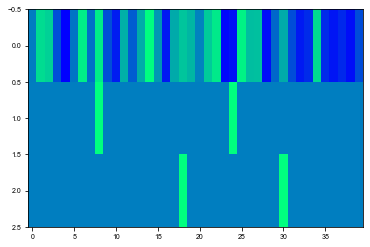

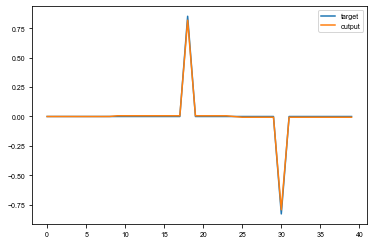

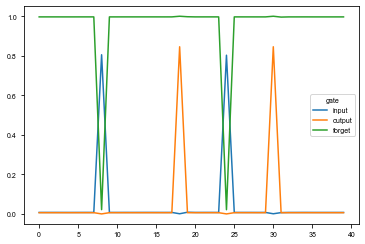

In [32]:
i_trial = 0
plt.figure()
plt.imshow(inputs[:, i_trial, :].T, aspect='auto', cmap='winter')

plt.figure()
plt.plot(labels[:, i_trial, 0], label='target')
plt.plot(output[:, i_trial, 0], label='output')
plt.legend()

plt.figure()
plt.plot(result['ingate'][:, i_trial, 0], label='input')
plt.plot(result['outgate'][:, i_trial, 0], label='output')
plt.plot(result['forgetgate'][:, i_trial, 0], label='forget')
plt.legend(title='gate')

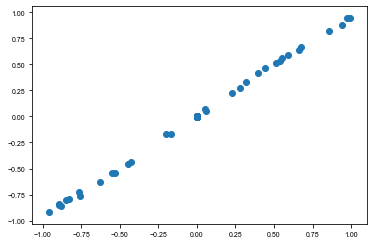

In [33]:
plt.figure()
plt.scatter(labels.flatten(), output.flatten())

# Supplementary Materials

Code for making publication quality figures as it appears in the paper.

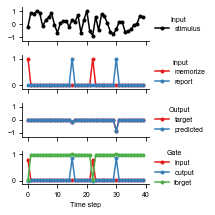

In [34]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 7
mpl.rcParams['font.family'] = 'arial'

i_trial = 1

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(3, 3))
for i in range(4):
    ax = axes[i]
    kwargs = {'marker': 'o', 'markersize': 3}
    cmap = mpl.cm.get_cmap('Set1')
    title = None
    if i == 0:
        ax.plot(inputs[:, i_trial, 0], label='stimulus', color='black', **kwargs)
        title = 'Input'
    elif i == 1:
        ax.plot(inputs[:, i_trial, 1], label='memorize', color=cmap(0), **kwargs)
        ax.plot(inputs[:, i_trial, 2], label='report', color=cmap(1), **kwargs)
        title = 'Input'
    elif i == 2:
        ax.plot(labels[:, i_trial, 0], label='target', color=cmap(0), **kwargs)
        ax.plot(output[:, i_trial, 0], label='predicted', color=cmap(1), **kwargs)
        title = 'Output'
#     elif i == 3:
#         ax.plot(result['input'][:, i_trial, 0], label='cell input', color=cmap(0), **kwargs)
#         ax.plot(result['cell'][:, i_trial, 0], label='cell state', color=cmap(1), **kwargs)
#         ax.plot(result['output'][:, i_trial, 0], label='cell output', color=cmap(2), **kwargs)
    else:
        ax.plot(result['ingate'][:, i_trial, 0], label='input', color=cmap(0), **kwargs)
        ax.plot(result['outgate'][:, i_trial, 0], label='output', color=cmap(1), **kwargs)
        ax.plot(result['forgetgate'][:, i_trial, 0], label='forget', color=cmap(2), **kwargs)
        title = 'Gate'
        ax.set_xlabel('Time step')
    
    l = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                  frameon=False, title=title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i in [1, 3]:
        ax.set_ylim([-0.15, 1.15])
        ax.set_yticks([0, 1])
    else:
        ax.set_ylim([-1.3, 1.3])
        ax.set_yticks([-1, 0, 1])
plt.tight_layout()
    
from pathlib import Path
fname = Path('figures/lstmvisualization')
fig.savefig(fname.with_suffix('.pdf'), transparent=True)
fig.savefig(fname.with_suffix('.png'), dpi=300)